# Master's thesis:
## Building an Activity Prediction Agent as part of a Multi-Agent Recommendation System for a More Efficient Energy Use in Private Households
#### submitted by Laura Löschmann
#### Student no. 587484

## 1. Imports

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner import RandomSearch
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import hickle as hkl
import pickle 
from sklearn.model_selection import ParameterGrid
import collections
from numpy.random import seed
tf.random.set_seed(1234)

import utils
import preprocessing_agent as prep
import LR_aval_use_agent as LR
import RF_aval_use_agent as RF
import NN_aval_use_agent as NN
import activity_agent as act
import eval_metric_act_agent as eval_act
import cold_start_NN as cs
import emissions_price_agent as emp
import recommendation_agent as rec

## 2. Data

In [2]:
data_h5 = pd.read_csv('CLEAN_House5.csv', parse_dates=True,index_col=0)
#data_h1 = pd.read_csv('CLEAN_House1.csv', parse_dates=True,index_col=0)
#data_h2 = pd.read_csv('CLEAN_House2.csv', parse_dates=True,index_col=0)
#data_h3 = pd.read_csv('CLEAN_House3.csv', parse_dates=True,index_col=0)
#data_h4 = pd.read_csv('CLEAN_House4.csv', parse_dates=True,index_col=0)

In [3]:
data_h5.head()

Unix  Aggregate  Appliance1  Appliance2  \
Time                                                                 
2013-09-26 09:56:09  1380189369        275           2           0   
2013-09-26 09:56:16  1380189376        273           2           0   
2013-09-26 09:56:23  1380189383        273           2           0   
2013-09-26 09:56:30  1380189390        273           2           0   
2013-09-26 09:56:36  1380189396        278           2           0   

                     Appliance3  Appliance4  Appliance5  Appliance6  \
Time                                                                  
2013-09-26 09:56:09           0           0          11           0   
2013-09-26 09:56:16           0           0          11           0   
2013-09-26 09:56:23           0           0          11           0   
2013-09-26 09:56:30           0           0          11           0   
2013-09-26 09:56:36           0           0          11           0   

                     Appliance7  Appliance8  Appliance9  Issues  
Time                                                             
2013-09-26 09:56:09           0           0           0       0  
2013-09-26 09:56:16           0           0           0       0  
2013-09-26 09:56:23           0           0           0       0  
2013-09-26 09:56:30           0           0           0       0  
2013-09-26 09:56:36           0           0           0       0

In [4]:
# Checking for NANs
data_h5.isnull().values.any()

False

In [5]:
data_h5.shape

(7430755, 12)

## 3. Predefined Values

In [2]:
# Features for the Availability Agent
aval_features = ['Month', 'Day_of_week', 'Hour', 'User_aval_t-1','User_aval_t-1week','User_aval']

In [3]:
# Usage and activity threshold for the Activity Agent Evaluation
usage_threshold = 0.2
activity_threshold = 0.2

### House 5

In [4]:
# Individual values for House 5
num_devices = 8
num_activities = 5
activity_vector = 'Activities_vector_h5.csv'
aval_off = True
on_threshold = 12

### House 1

In [ ]:
# Individual values for House 1
num_devices = 5
num_activities = 4
activity_vector = 'Activities_vector_h1.csv'
aval_off = True
on_threshold = 12

### House 2

In [7]:
# Individual values for House 2
num_devices = 7
num_activities = 4
activity_vector = 'Activities_vector_h2.csv'
aval_off = True
on_threshold = 12

### House 3

In [8]:
# Individual values for House 3
num_devices = 7
num_activities = 4
activity_vector = 'Activities_vector_h3.csv'
aval_off = True
on_threshold = 12

### House 4

In [9]:
# Individual values for House 3
num_devices = 6
num_activities = 4
activity_vector = 'Activities_vector_h4.csv'
aval_off = True
on_threshold = 12

## 4. Data Preprocessing

### House 5

In [9]:
# Preprocessing pipeline for House 5
preprocessing_pipeline = Pipeline(steps=[
                        ('hourly_grouping',prep.hourly_grouping()),
                        ('time_features',prep.time_features()),
                        ('app_labels_h5',prep.appliance_label_house5()),
                        ('aval_features',prep.availability(on_threshold)),
                        ('device_usage',prep.device_usage(num_devices,on_threshold))
                        ])
data_prep = preprocessing_pipeline.fit_transform(data_h5)

In [10]:
# Save the data preprocessing of House 5
data_prep.to_pickle('H5_data_prep')

In [5]:
# Load the data preprocessing of House 5
data_prep = pd.read_pickle('H5_data_prep')

In [6]:
data_prep.shape

(14373, 38)

In [7]:
data_prep.head()

Month  Day_of_week  Hour  User_aval_t-1week  \
Date                                                               
2013-10-03 09:00:00     10            3     9                  0   
2013-10-03 10:00:00     10            3    10                  0   
2013-10-03 11:00:00     10            3    11                  0   
2013-10-03 12:00:00     10            3    12                  0   
2013-10-03 13:00:00     10            3    13                  0   

                     User_aval_t-1  User_aval  Tumble_Dryer  Washing_machine  \
Date                                                                           
2013-10-03 09:00:00              0          0             0                3   
2013-10-03 10:00:00              0          0             0                3   
2013-10-03 11:00:00              0          0             0                3   
2013-10-03 12:00:00              0          0             0                3   
2013-10-03 13:00:00              0          0             0                3   

                     Dishwasher  Desktop_Computer  ...  Kettle_usage_t-1  \
Date                                               ...                     
2013-10-03 09:00:00         273                 7  ...                 0   
2013-10-03 10:00:00           0                 7  ...                 0   
2013-10-03 11:00:00           0                 7  ...                 0   
2013-10-03 12:00:00           0                 7  ...                 0   
2013-10-03 13:00:00           0                 7  ...                 0   

                     Toaster_usage_t-1  Tumble_Dryer_usage_t-1week  \
Date                                                                 
2013-10-03 09:00:00                  0                           0   
2013-10-03 10:00:00                  0                           0   
2013-10-03 11:00:00                  0                           0   
2013-10-03 12:00:00                  0                           0   
2013-10-03 13:00:00                  0                           0   

                     Washing_machine_usage_t-1week  Dishwasher_usage_t-1week  \
Date                                                                           
2013-10-03 09:00:00                              0                         0   
2013-10-03 10:00:00                              0                         0   
2013-10-03 11:00:00                              0                         0   
2013-10-03 12:00:00                              0                         0   
2013-10-03 13:00:00                              0                         0   

                     Desktop_Computer_usage_t-1week  \
Date                                                  
2013-10-03 09:00:00                               0   
2013-10-03 10:00:00                               0   
2013-10-03 11:00:00                               0   
2013-10-03 12:00:00                               0   
2013-10-03 13:00:00                               0   

                     Television_Site_usage_t-1week  Microwave_usage_t-1week  \
Date                                                                          
2013-10-03 09:00:00                              0                        0   
2013-10-03 10:00:00                              0                        0   
2013-10-03 11:00:00                              0                        0   
2013-10-03 12:00:00                              0                        0   
2013-10-03 13:00:00                              0                        0   

                     Kettle_usage_t-1week  Toaster_usage_t-1week  
Date                                                              
2013-10-03 09:00:00                     0                      0  
2013-10-03 10:00:00                     0                      0  
2013-10-03 11:00:00                     0                      0  
2013-10-03 12:00:00                     0                      0  
2013-10-03 13:00:00                     0               

In [8]:
# Checking for NANs
data_prep.isnull().values.any()

False

In [9]:
# Features for the Usage Agent for House 5
columns = list(data_prep.columns)
columns = columns[0:6]+columns[-num_devices*2:]+columns[6+num_devices:6+(num_devices*2)]

usage_features = columns

### House 1

In [ ]:
# Preprocessing pipeline for House 1
preprocessing_pipeline = Pipeline(steps=[
                        ('hourly_grouping',prep.hourly_grouping()),
                        ('time_features',prep.time_features()),
                        ('app_labels_h1',prep.appliance_label_house1()),
                        ('aval_features',prep.availability(on_threshold)),
                        ('device_usage',prep.device_usage(num_devices,on_threshold))
                        ])
data_prep = preprocessing_pipeline.fit_transform(data_h1)

In [ ]:
# Save the data preprocessing of House 1
data_prep.to_pickle('H1_data_prep')

In [ ]:
# Load the data preprocessing of House 1
data_prep = pd.read_pickle('H1_data_prep')

In [ ]:
data_prep.shape

In [12]:
data_prep.head()

NameError: name 'data_prep' is not defined

In [ ]:
data_prep.isnull().values.any()

In [ ]:
# Features for the Usage Agent for House 1
columns = list(data_prep.columns)
columns = columns[0:6]+columns[-num_devices*2:]+columns[6+num_devices:6+(num_devices*2)]

usage_features = columns

### House 2

In [ ]:
# Preprocessing pipeline for House 2
preprocessing_pipeline = Pipeline(steps=[
                        ('hourly_grouping',prep.hourly_grouping()),
                        ('time_features',prep.time_features()),
                        ('app_labels_h2',prep.appliance_label_house2()),
                        ('aval_features',prep.availability(on_threshold)),
                        ('device_usage',prep.device_usage(num_devices,on_threshold))
                        ])
data_prep = preprocessing_pipeline.fit_transform(data_h2)

In [ ]:
# Save the data preprocessing of House 2
data_prep.to_pickle('H2_data_prep')

In [ ]:
# Load the data preprocessing of House 2
data_prep = pd.read_pickle('H2_data_prep')

In [ ]:
data_prep.shape

In [ ]:
data_prep.head()

In [ ]:
data_prep.isnull().values.any()

In [ ]:
# Features for the Usage Agent for House 2
columns = list(data_prep.columns)
columns = columns[0:6]+columns[-num_devices*2:]+columns[6+num_devices:6+(num_devices*2)]

usage_features = columns

### House 3

In [ ]:
# Preprocessing pipeline for House 3
preprocessing_pipeline = Pipeline(steps=[
                        ('hourly_grouping',prep.hourly_grouping()),
                        ('time_features',prep.time_features()),
                        ('app_labels_h3',prep.appliance_label_house3()),
                        ('aval_features',prep.availability(on_threshold)),
                        ('device_usage',prep.device_usage(num_devices,on_threshold))
                        ])
data_prep = preprocessing_pipeline.fit_transform(data_h3)

In [ ]:
# Save the data preprocessing of House 3
data_prep.to_pickle('H3_data_prep')

In [ ]:
# Load the data preprocessing of House 3
data_prep = pd.read_pickle('H3_data_prep')

In [13]:
data_prep.shape

NameError: name 'data_prep' is not defined

In [ ]:
data_prep.head()

In [ ]:
data_prep.isnull().values.any()

In [ ]:
# Features for the Usage Agent for House 3
columns = list(data_prep.columns)
columns = columns[0:6]+columns[-num_devices*2:]+columns[6+num_devices:6+(num_devices*2)]

usage_features = columns

### House 4

In [ ]:
# Preprocessing pipeline for House 4
preprocessing_pipeline = Pipeline(steps=[
                        ('hourly_grouping',prep.hourly_grouping()),
                        ('time_features',prep.time_features()),
                        ('app_labels_h4',prep.appliance_label_house4()),
                        ('aval_features',prep.availability(on_threshold)),
                        ('device_usage',prep.device_usage(num_devices,on_threshold))
                        ])
data_prep = preprocessing_pipeline.fit_transform(data_h4)

In [ ]:
# Save the data preprocessing of House 4
data_prep.to_pickle('H4_data_prep')

In [ ]:
# Load the data preprocessing of House 4
data_prep = pd.read_pickle('H4_data_prep')

In [ ]:
data_prep.shape

In [ ]:
data_prep.head()

In [ ]:
data_prep.isnull().values.any()

In [14]:
# Features for the Usage Agent for House 4
columns = list(data_prep.columns)
columns = columns[0:6]+columns[-num_devices*2:]+columns[6+num_devices:6+(num_devices*2)]

usage_features = columns

NameError: name 'data_prep' is not defined

## 5. Data Graphics

In [15]:
# Get device consumption data from preprocessing dataset
hh = data_prep.iloc[:,6:6+num_devices]
# Subset representing a day of data
hh_day= hh['2013-10-05 00:00:00':'2013-10-05 23:00:00']

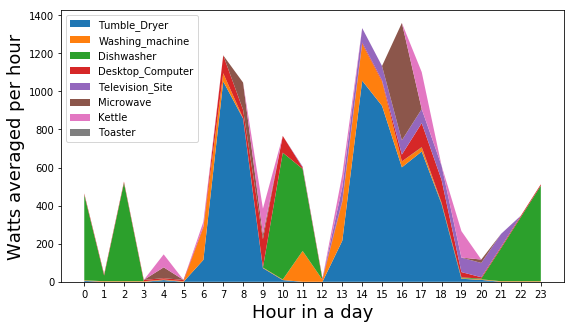

In [16]:
# Set size of plot
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
# Stackplot
ax.stackplot(list(range(24)), np.transpose(hh_day.values), labels=hh_day.columns.values)
plt.xlabel('Hour in a day', fontsize=18)
plt.ylabel('Watts averaged per hour', fontsize=18)
plt.xticks(np.arange(0, 24, 1.0))
ax.legend(loc=2)

In [17]:
# Subsets representing a week of data
hh_week = hh['2013-10-21 00:00:00':'2013-10-27 23:00:00']
hh_week2 = hh['2013-10-28 00:00:00':'2013-11-03 23:00:00']

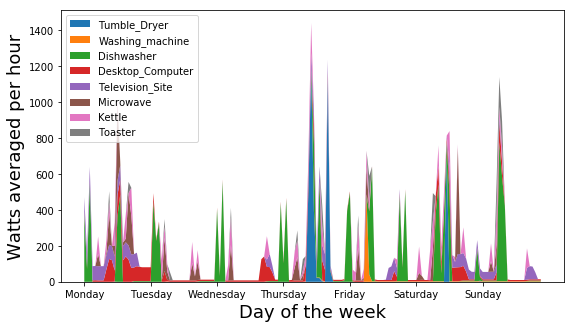

In [18]:
# Set size of plot
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
# Stackplot
ax.stackplot(list(range(166)), np.transpose(hh_week.values), labels=hh_week.columns.values)
plt.xlabel('Day of the week', fontsize=18)
plt.ylabel('Watts averaged per hour', fontsize=18)
plt.xticks(np.arange(0, 166, 24.0),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.legend(loc=2)

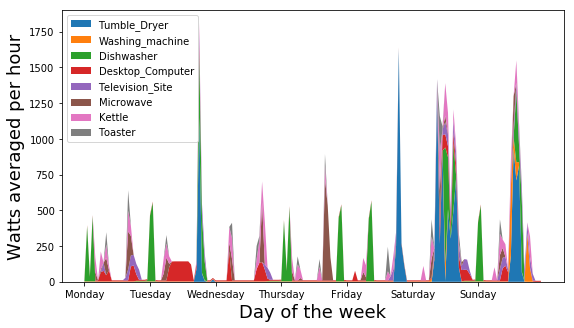

In [19]:
# Set size of plot
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
# Stackplot
ax.stackplot(list(range(168)), np.transpose(hh_week2.values), labels=hh_week2.columns.values)
plt.xlabel('Day of the week', fontsize=18)
plt.ylabel('Watts averaged per hour', fontsize=18)
plt.xticks(np.arange(0, 168, 24.0),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.legend(loc=2)

/Users/lauraloschmann/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


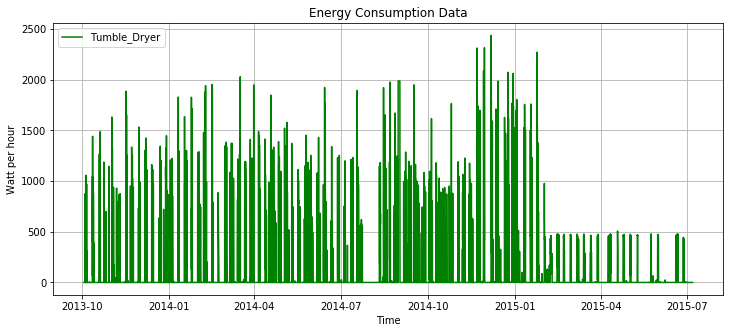

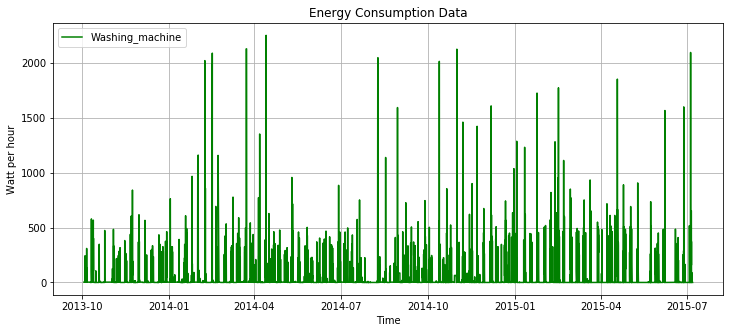

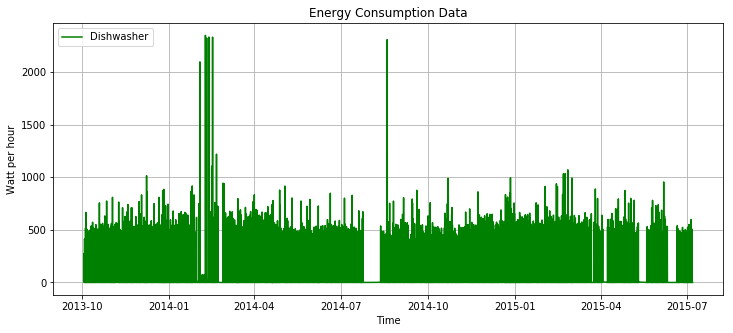

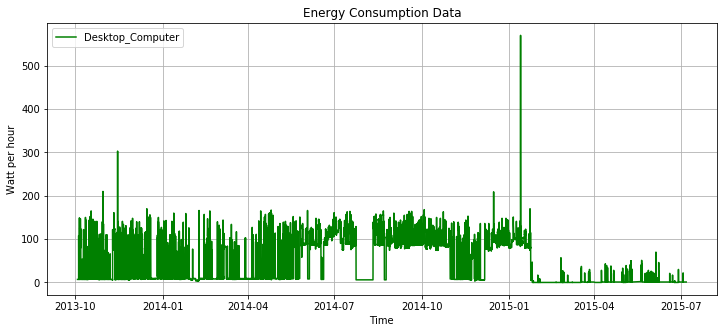

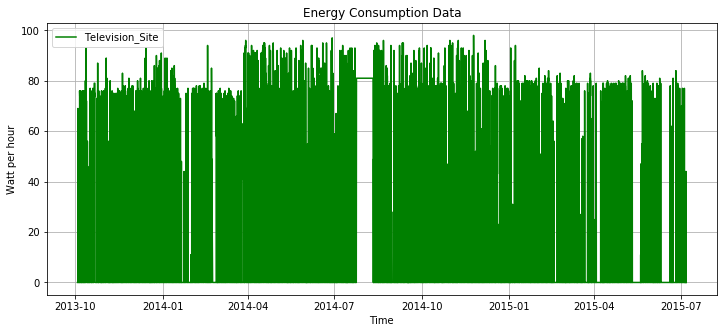

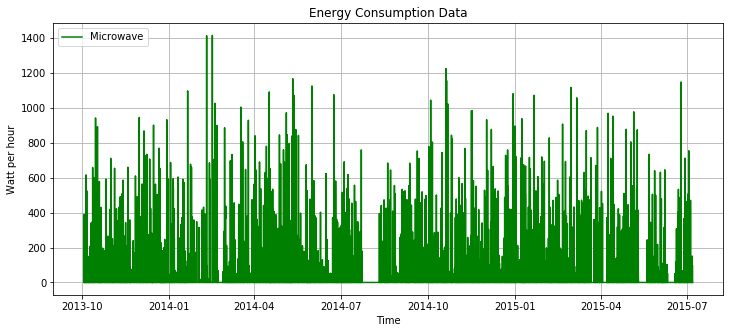

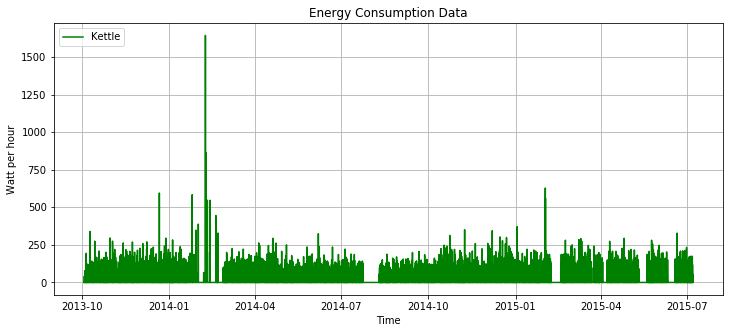

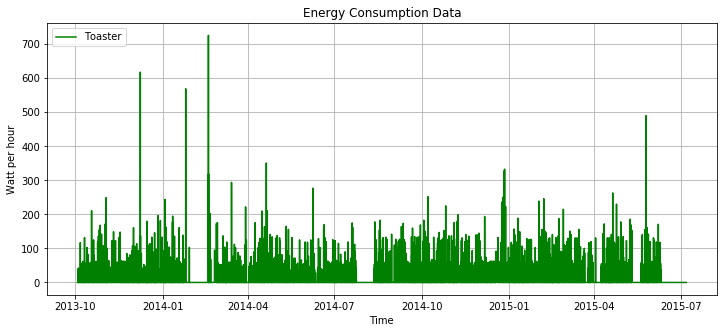

In [20]:
# Plot the energy consumption data per device over the whole period
columns = hh.columns.tolist()
for col in columns:
    #plt.rc('font', size=12)
    #fig, ax = plt.subplots(4,2)
    #fig.set_size_inches(6, 6)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(hh.index, hh[col],color='green', label=col)

    ax.set_xlabel('Time')
    ax.set_ylabel('Watt per hour')
    ax.set_title('Energy Consumption Data')
    ax.grid(True)
    ax.legend(loc='upper left');

## 6. Availability Agent Evaluation

### Logistic Regression Evaluation

In [ ]:
LR_auc = {}
validation_split = 0.2

# Perform and evaluate the predictions of the Availability Agent using a logistic regression over a period of one year
# starting with 28 days of data
for i in range(28,394):
    data = data_prep.iloc[:24+24*i,:]
    
    # Get indices and split value for splitting the data into training and test set
    data_size = len(data)-24
    indices = list(range(data_size))
    split = int(np.floor(validation_split * data_size))
    
    # Build the Availability Agent pipeline using the logistic regression model
    aval_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(aval_features)),
                    ('LogisticRegression',LR.Availability_Agent_Logistic_Regression(indices,split))
                    ])
    auc_score, aval_pred, X_test = aval_pipeline.fit_transform(data)
    
    # Save auc score in a dictionary
    LR_auc.update({i:round(auc_score,2)})
    
LR_auc_avg = utils.list_average(list(LR_auc.values()))
print(LR_auc_avg)

### Random Forest Evaluation

In [10]:
# number of decision trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = np.linspace(0.1, 0.6, 10, endpoint=True) #[2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = np.linspace(0.1, 0.3, 5, endpoint=True)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
RF_auc = {}
validation_split = 0.2

data = data_prep.iloc[:24*28,:]

# Get indices and split value for splitting the data into training and test set
data_size = len(data)-(24+24*21)
indices = list(range(data_size))
split = int(np.floor(validation_split * data_size))

# Build the Availability Agent pipeline for the first random forest model
aval_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(aval_features)),
                    ('RandomForest',RF.Availability_Agent_First_Random_Forest(indices,split))
                    ])
auc_score, params = aval_pipeline.fit_transform(data)

# Save auc score in a dictionary
RF_auc.update({28:round(auc_score,2)})

cut = 0

# Perform and evaluate the predictions of the Availability Agent using a random forest over a period of one year
# starting with 28 days of data
for i in range(29,394):
    data = data_prep.iloc[:24*i,:]

    # Get indices and split value for splitting the data into training and test set
    data_size = len(data)-24
    indices = list(range(data_size))
    split = int(np.floor(validation_split * data_size))
    
    # Tune the model's hyperparameter after every 4 months and cut off the oldest two months (=60 days) of data
    if i%120==0:
        cut+=60*24
        aval_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(aval_features)),
                    ('RandomForest',RF.Availability_Agent_Random_Forest(indices,split,params,True,random_grid))
                    ])
        auc_score, params, y_pred, X_test = aval_pipeline.fit_transform(data)
    else:
        aval_pipeline = Pipeline(steps=[
                        ('FeatureSelector',prep.FeatureSelector(aval_features)),
                        ('RandomForest',RF.Availability_Agent_Random_Forest(indices,split,params,False,random_grid))
                        ])
        auc_score, params, y_pred, X_test = aval_pipeline.fit_transform(data)
    
    # Save auc score in a dictionary
    RF_auc.update({i:round(auc_score,2)})

RF_auc_avg = utils.list_average(list(RF_auc.values()))
print(RF_auc_avg)

### Neural network evaluation

In [ ]:
# Availability agent
NN_auc = {}
validation_split = 0.2

data = data_prep.iloc[:24*28,:]

# Get indices and split value for splitting the data into training and test set
data_size = len(data)-(24+24*21)
indices = list(range(data_size))
split = int(np.floor(validation_split * data_size))

# Build the Availability Agent pipeline to tune a neural network model 
aval_tune_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(aval_features)),
                    ('NeuralNetwork_Initalized_Tuning',NN.Availability_Agent_Neural_Network_tuning(indices,split))
                    ])
model = aval_tune_pipeline.fit_transform(data)

cut=0

# Perform and evaluate the predictions of the Availability Agent using a neural network over a period of one year
# starting with 28 days of data
for i in range(28,394):
    data = data_prep.iloc[cut:24*i,:]
    
    # Get indices and split value for splitting the data into training and test set
    data_size = len(data)-(24+24*21)
    indices = list(range(data_size))
    split = int(np.floor(validation_split * data_size))
    
    # Tune the model's hyperparameter after every 4 months (=120 days) and cut off the oldest two months (=60 days) of data
    if i%120==0:
        cut+=60*24
        model = aval_tune_pipeline.fit_transform(data)
    
    # Build the Availability Agent pipeline 
    aval_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(aval_features)),
                    ('NeuralNetwork',NN.Availability_Agent_Neural_Network(indices,split,model))
                    ])

    auc_score, y_pred, X_test = aval_pipeline.fit_transform(data)
    
    # Save auc score in a dictionary
    NN_auc.update({i:round(auc_score,2)})
    
NN_auc_avg = utils.list_average(list(NN_auc.values()))
print(NN_auc_avg)
#plot_dict(NN_auc,'Availability Agent - Neural Network','days','AUC','NN_auc_H4')

## 7. Usage Agent & Activity Agent Evaluation

### Logistic Regression

In [ ]:
columns = usage_features[-num_devices:]
validation_split = 0.2
LR_use = pd.DataFrame(columns = columns)
LR_equal = {}

# Perform and evaluate the predictions of the Usage Agent using a logistic regression and the Activity Agent 
# over a period of one year starting with 28 days of data
for i in range(28,394):
    data = data_prep.iloc[:24*i,:]

    # Get indices and split value for splitting the data into training and test set
    data_size = len(data)-24
    indices = list(range(data_size))
    split = int(np.floor(validation_split * data_size))
    
    # Build the Usage Agent pipeline
    usage_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(usage_features)),
                    ('Logistic_Regression_usage',LR.Usage_Agent_Logistic_Regression(num_devices,indices,split))
                    ])
    auc_scores, usage_pred = usage_pipeline.fit_transform(data)
    
    # Save auc scores in a dataframe
    LR_use = LR_use.append(auc_scores)
    
    # Build the Activity Agent Evaluation pipeline
    activity_pipeline = Pipeline(steps=[
                      ('activity',act.Activity_Agent(num_devices, num_activities,activity_vector)),
                      ('activity_evaluation',eval_act.Activity_Agent_Evaluation(usage_threshold,activity_threshold,num_devices,num_activities, activity_vector))
    ])
    EQUAL = activity_pipeline.fit_transform(usage_pred)
    
    # Save EQUAL score in a dictionary
    LR_equal.update({i:EQUAL})
    LR_use = LR_use.reset_index(drop=True)
    
# Get the average auc scores per device
LR_auc_dict = {}
for col in columns:
    l = LR_use[col].tolist()
    print(col[:-6])
    auc = round(utils.list_average(l),2)
    print(auc)
    LR_auc_dict.update({col:auc})
    #hkl.dump([LR_auc_dict], 'LR_auc_dev')
    
# Get the average EQUAL score    
EQUAL_avg = utils.list_average(list(LR_equal.values()))
print(EQUAL_avg)

### Random Forest

In [11]:
# number of decision trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = np.linspace(0.1, 0.6, 10, endpoint=True) #[2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = np.linspace(0.1, 0.3, 5, endpoint=True)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
columns = usage_features[-num_devices:]
validation_split = 0.2
RF_use = pd.DataFrame(columns = columns)
RF_equal = {}

data = data_prep.iloc[:24*28,:]

# Get indices and split value for splitting the data into training and test set
data_size = len(data)-(24+24*21)
indices = list(range(data_size))
split = int(np.floor(validation_split * data_size))

# Build the Usage Agent pipeline to tune a random forest model 
usage_tune_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(usage_features)),
                    ('RandomForest',RF.Usage_Agent_Random_Forest_tuning(num_devices,indices,split,random_grid))
                    ])
auc_scores, usage_pred, params_dict = usage_tune_pipeline.fit_transform(data)

# Save auc scores in a dataframe
RF_use = RF_use.append(auc_scores)

# Build the Activity Agent Evaluation pipeline
activity_pipeline = Pipeline(steps=[
                      ('activity',act.Activity_Agent(num_devices, num_activities,activity_vector)),
                      ('activity_evaluation',eval_act.Activity_Agent_Evaluation(usage_threshold,activity_threshold,num_devices,num_activities, activity_vector))
    ])    
EQUAL = activity_pipeline.fit_transform(usage_pred)

# Save EQUAL score in a dictionary
RF_equal.update({28:EQUAL})

# Perform and evaluate the predictions of the Usage Agent using a random forest and the Activity Agent 
# over a period of one year starting with 28 days of data
for i in range(29,394):
    data = data_prep.iloc[:24*i,:]
    
    # Get indices and split value for splitting the data into training and test set
    data_size = len(data)-(24+24*21)
    indices = list(range(data_size))
    split = int(np.floor(validation_split * data_size))
    
    # Tune the model's hyperparameter after every 4 months (=120 days) and cut off the oldest two months (=60 days) of data
    if i%120==0:
        # Fit the Usage Agent pipeline for tuning a random forest
        auc_scores, usage_pred, params_dict = usage_tune_pipeline.fit_transform(data)
    else:
        # Build the Usage Agent pipeline
        usage_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(usage_features)),
                    ('Random_Forest_usage',RF.Usage_Agent_Random_Forest(num_devices,indices,split,random_grid,params_dict))
                    ])
        auc_scores, usage_pred = usage_pipeline.fit_transform(data)
        
    # Save auc scores in a dataframe    
    RF_use = RF_use.append(auc_scores)
    
    # Fit the Activity Agent Evaluation pipeline
    EQUAL = activity_pipeline.fit_transform(usage_pred)
    
    # Save EQUAL score in a dictionary
    RF_equal.update({i:EQUAL})
    RF_use = RF_use.reset_index(drop=True)

# Get the average auc score per device
RF_auc_dict = {}
for col in columns:
    l = RF_use[col].tolist()
    print(col[:-6])
    auc = round(utils.list_average(l),2)
    print(auc)
    RF_auc_dict.update({col:auc})
    hkl.dump([RF_auc_dict], 'RF_auc_dev')

# Get the average EQUAL score 
EQUAL_avg = utils.list_average(list(RF_equal.values()))
print(EQUAL_avg)

### Neural Network

In [ ]:
columns = usage_features[-num_devices:]
validation_split = 0.2
NN_use = pd.DataFrame(columns = columns)
NN_equal = {}

data = data_prep.iloc[:24*28,:]

# Get indices and split value for splitting the data into training and test set
data_size = len(data)-(24+24*21)
indices = list(range(data_size))
split = int(np.floor(validation_split * data_size))

# Build the Usage Agent pipeline to tune a neural network
usage_tune_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(usage_features)),
                    ('NeuralNetwork_Initalized_Tuning',NN.Usage_Agent_Neural_Network_tuning(num_devices,indices,split))
                   ])
model_dict = usage_tune_pipeline.fit_transform(data)

cut=0

# Perform and evaluate the predictions of the Usage Agent using a neural network and the Activity Agent 
# over a period of one year starting with 28 days of data
for i in range(28,394):
    data = data_prep.iloc[cut:24*i,:]
    
    # Get indices and split value for splitting the data into training and test set
    data_size = len(data)-(24+24*21)
    indices = list(range(data_size))
    split = int(np.floor(validation_split * data_size))
    
    # Tune the model's hyperparameter after every 4 months (=120 days) and cut off the oldest two months (=60 days) of data
    if i%120==0:
        cut+=60*24
        # Fit the Usage Agent pipeline for tuning a neural network model
        model_dict = usage_tune_pipeline.fit_transform(data)
    
    # Build the Usage Agent pipeline
    usage_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(usage_features)),
                    ('NeuralNetwork',NN.Usage_Agent_Neural_Network(num_devices,indices,split,model_dict))
                    ])
    auc_scores, usage_pred = usage_pipeline.fit_transform(data)
    
    # Save auc scores in a dataframe
    NN_use = NN_use.append(auc_scores)
    
    # Build the Activity Agent Evaluation pipeline
    activity_pipeline = Pipeline(steps=[
                      ('activity',act.Activity_Agent(num_devices, num_activities,activity_vector)),
                      ('activity_evaluation',eval_act.Activity_Agent_Evaluation(usage_threshold,activity_threshold,num_devices,num_activities, activity_vector))
    ])
    EQUAL = activity_pipeline.fit_transform(usage_pred)

    # Save EQUAL scores in a dictionary
    NN_equal.update({i:EQUAL})
    NN_use = NN_use.reset_index(drop=True)

# Get the average auc scores per device
NN_auc_dict = {}
for col in columns:
    l = NN_use[col].tolist()
    print(col[:-6])
    auc = round(utils.list_average(l),2)
    print(auc)
    NN_auc_dict.update({col:auc})
    
# Get the average EQUAL score 
EQUAL_avg = utils.list_average(list(NN_equal.values()))
print(EQUAL_avg)

## 8. Cold Start Problem Evaluation

### Availability Agent

In [ ]:
total_days = 413
test_begin = 393

data = data_prep.iloc[:24*total_days,:]
cut=0
day = 28
NN_aval_auc = {}

# Build the Availability Agent pipeline to tune a neural network model
aval_tune_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(aval_features)),
                    ('NeuralNetwork_Initalized_Tuning',cs.Availability_Agent_Neural_Network_tuning_cold_start(day,cut))
                    ])
model = aval_tune_pipeline.fit_transform(data)

# Perform and evaluate the predictions of the Availability Agent using a neural network over a period of one year 
# starting with 28 days of data and using the same test set
for day in range(28,394):
    if day%120==0:
        cut+=60*24
        # Fit the Availability Agent pipeline for tuning
        model = aval_tune_pipeline.fit_transform(data)
    
    # Build the Availability pipeline
    aval_pipeline = Pipeline(steps=[
                ('FeatureSelector',prep.FeatureSelector(aval_features)),
                ('NeuralNetwork',cs.Availability_Agent_Neural_Network_cold_start(day,test_begin,total_days,model,cut))
                ])
    auc_score = aval_pipeline.fit_transform(data)
    
    # Save auc score in a dictionary
    d = day-27
    NN_aval_auc.update({d:round(auc_score,2)})
    
# Get the average auc score
auc_avg = utils.list_average(list(NN_aval_auc.values()))
#plot_dict(NN_aval_auc,'Cold Start: Availability Agent - Neural Network','days','AUC','NN_aval_cs_H5',0.79)

### Usage Agent & Activity Agent 

In [ ]:
total_days = 413
test_begin = 393

columns = usage_features[-num_devices:]
NN_usage_auc = pd.DataFrame(columns = columns)
NN_act_equal = {}

data = data_prep.iloc[:24*total_days,:]
cut=0
day = 28

# Build the Usage Agent pipeline to tune a neural network model
usage_tune_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(usage_features)),
                    ('NeuralNetwork_Initalized_Tuning',cs.Usage_Agent_Neural_Network_tuning_cold_start(num_devices,day,cut))
                    ])
model_dict = usage_tune_pipeline.fit_transform(data)

for day in range(28,393):
    if day%120==0:
        cut+=60*24
        # Fit the Usage Agent pipeline for tuning
        model_dict = usage_tune_model_pipeline.fit_transform(data)
    
    # Build the Usage Agent pipeline
    usage_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(usage_features)),
                    ('NeuralNetwork',cs.Usage_Agent_Neural_Network_cold_start(num_devices,day,test_begin,total_days,model_dict,cut))
                    ])
    auc_scores, usage_pred = usage_pipeline.fit_transform(data)
    
    # Save auc scores in a dataframe
    NN_usage_auc = NN_usage_auc.append(auc_scores)
    
    # Build the Activity Agent Evaluation pipeline
    activity_pipeline = Pipeline(steps=[
                      ('activity',act.Activity_Agent(num_devices, num_activities,activity_vector)),
                      ('activity_evaluation',eval_act.Activity_Agent_Evaluation(usage_threshold,activity_threshold,num_devices,num_activities, activity_vector))
    ])
    EQUAL = activity_pipeline.fit_transform(usage_pred)
    
    # Save EQUAL score in a dictionary
    d = day-27
    NN_act_equal.update({d:EQUAL})
    NN_usage_auc = NN_usage_auc.reset_index(drop=True)

# Get the average auc scores per device
NN_auc_dict = {}
for col in columns:
    l = NN_usage_auc[col].tolist()
    print(col[:-6])
    auc = round(utils.list_average(l),2)
    print(auc)
    NN_auc_dict.update({col:auc})
    #plot_dict(NN_usage_auc[col],'Cold Start: Usage Agent - Neural Network','days','AUC','NN_usage_auc',0.79)
    
# Get the average EQUAL score 
EQUAL_avg = utils.list_average(list(NN_act_equal.values()))

## 9. Recommendation System Evaluation

In [ ]:
# Check for complete data
# Dataset is complete if there is data for every hour of every day in the dataset
temp = data_prep.copy()
temp['date'] = temp.index.to_frame()
temp['date'] = pd.to_datetime(temp['date']).dt.date
temp.groupby("date").size().value_counts()

In [11]:
# Add missing data rows (= hours not existent in the dataset)
data = data_prep.copy()

begin = data.index[0]
end = data.index[-1]

d0 = begin
d1 = end 
delta = d1 - d0
periods =delta.days*24

# Create empty dataframe with hourly datetime index from 2013-09-26 to 2015-07-06
index = pd.date_range(str(begin)[:10], periods=periods, freq='H')
col = data.columns
df = pd.DataFrame(index=index, columns=col)

# Forward data from dataset to empty dataframe
temp = df.merge(data,how='left',left_index=True, right_index=True)

temp.fillna(0.01,inplace = True)

data_new = temp.iloc[12:,(temp.shape[1]//2):]

columns = data_new.columns

for col in columns:
    data_new = data_new.rename(columns={col: col[:-2]})
    
data_new = data_new.astype(int)

data_pr = data_new#.iloc[4320:,:]

In [ ]:
# Get the input for the Recommendation Agent from all other agents
validation_split = 0.2
cut = 0
rec_dfs = {}

data = data_pr.iloc[:24*28,:]

# Get indices and split value for splitting the data into training and test set
data_size = len(data)-(24+24*21)
indices = list(range(data_size))
split = int(np.floor(validation_split * data_size))

# Build the Availability Agent pipeline for tuning a neural network
aval_tune_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(aval_features)),
                    ('NeuralNetwork_Initalized_Tuning',NN.Availability_Agent_Neural_Network_tuning(indices,split))
                    ])
model = aval_tune_pipeline.fit_transform(data)#

# Build Usage Agent pipeline for tuning a neural network
usage_tune_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(usage_features)),
                    ('NeuralNetwork_Initalized_Tuning',NN.Usage_Agent_Neural_Network_tuning(num_devices,indices,split))
                   ])
model_dict = usage_tune_pipeline.fit_transform(data)

# Perform the predictions of the Availability Agent and Usage Agent using a neural network, the Activity Agent, 
# the Emissions Agent and the Price Agent over a period of one year starting with 28 days of data
for i in range(29,394):
    data = data_pr.iloc[cut:24*i,:]
    
    # Get indices and split value for splitting the data into training and test set
    data_size = len(data)-(24+24*21)
    indices = list(range(data_size))
    split = int(np.floor(validation_split * data_size))
    
    # Tune the models' hyperparameter after every 4 months (=120 days) and cut off the oldest two months (=60 days) of data
    if i%120==0:
        cut+=60*24
        data = data_pr.iloc[cut:24*i,:]
        
        # Get indices and split value for splitting the data into training and test set
        data_size = len(data)-(24+24*21)
        indices = list(range(data_size))
        split = int(np.floor(validation_split * data_size))
        
        # Fit the Availability Agent pipeline for tuning a neural network
        model = aval_tune_pipeline.fit_transform(data)
        # Fit the Usage Agent pipeline for tuning a neural network
        model_dict = usage_tune_pipeline.fit_transform(data)

    # Build Availability Agent pipeline
    aval_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(aval_features)),
                    ('NeuralNetwork',NN.Availability_Agent_Neural_Network(indices,split,model))
                    ])
    auc_score, aval_pred, aval_X_test = aval_pipeline.fit_transform(data)
    availability_prediction = pd.DataFrame(aval_pred, columns=['aval'], index = aval_X_test.index)
    
    # Get recommendation horizon
    date_begin = availability_prediction.tail(24).index[0]
    date_end = availability_prediction.tail(24).index[-1]
    date_begin = str(date_begin)
    date_end = str(date_end)
    
    # Workaround for the mismatch of emissions and price data availability 
    if date_begin[:4]=='2014':
        year1 = '2019'
    else: 
        year1 = '2020'
    
    if date_end[:4]=='2014':
        year2 = '2019'
    else: 
        year2 = '2020' 
    
    # Convert format of the dates and hours for the Emissions Agent and the Price Agent
    date1_ci = year1+date_begin[4:10]
    date2_ci = year2+date_end[4:10]
    begin_ci = year1+date_begin[4:10]+'T'+date_begin[-8:-3]+'Z'
    end_ci = year2+date_end[4:10]+'T'+date_end[-8:-5]+'30Z'
    date1_pr = date_begin[8:10]+'.'+date_begin[5:7]+'.'+year1
    date2_pr = date_end[8:10]+'.'+date_end[5:7]+'.'+year2
    begin_pr = date_begin[-8:]
    end_pr = date_end[-8:]

    # Build the Activity Pipeline (Usage Agent + Activity Agent)
    activity_pipeline = Pipeline(steps=[
                    ('FeatureSelector',prep.FeatureSelector(usage_features)),
                    ('NeuralNetwork',NN.Usage_Agent_Neural_Network(num_devices,indices,split,model_dict)),
                    ('activity',act.Activity_Agent(num_devices, num_activities,activity_vector))
                    ])
    activity_prediction = activity_pipeline.fit_transform(data)
    activity_prediction.set_index(aval_X_test.index[-24:], inplace=True)

    # Build the Emissions Agent pipeline
    ca_pipeline = Pipeline(steps=[
              ('carbon_intensity', emp.Emissions_Agent(date1_ci,date2_ci,begin_ci,end_ci))
              ])
    ca_intensity = ca_pipeline.fit_transform(X=None)
    ca_intensity.set_index(aval_X_test[-24:].index, inplace=True)

    # Build the Price Agent pipeline
    pr_pipeline = Pipeline(steps=[
              ('price_value', emp.Price_Agent(date1_pr,date2_pr,begin_pr,end_pr))
              ])
    price_table = pr_pipeline.fit_transform(None)
    price_table.set_index(aval_X_test[-24:].index, inplace=True)

    # Merge the output dataframes from the Availability Agent, the Activity Agent, the Emissions Agent and the Price Agent
    rec_data = ca_intensity.merge(price_table['price'],left_index=True,right_index=True)
    rec_data = rec_data.merge(availability_prediction[-24:], left_index=True, right_index=True)
    rec_data = rec_data.merge(activity_prediction.iloc[:,-num_activities:],left_index=True, right_index=True)
    rec_data = rec_data.merge(activity_prediction.iloc[:,:num_devices],left_index=True, right_index=True)
    
    # Store data for the Recommendation Agent in a dictionary
    rec_dfs.update({i:rec_data})

In [13]:
# Save rec_dfs
with open("H5rec_dfs.pkl", "wb") as pkl_handle:
    pickle.dump(rec_dfs, pkl_handle)

In [12]:
# Load rec_dfs
with open("H5rec_dfs.pkl", "rb") as pkl_handle:
    rec_dfs = pickle.load(pkl_handle)

### Grid Search

In [13]:
emissions_ratio = 1.0
aval_threshold = 0.2
dev_avg_con = {}

# Set the parameters for grid search
params = {'aval_threshold':[0.15,0.25,0.35,0.5,0.65],
          'activity_threshold':[0.15,0.25,0.35,0.5,0.75]}
          #'emissions_ratio':[0.0,0.5,1.0],
          #'aval_off':[True,False]}

# Set the estimator
estimator = rec.Recommendation_Agent(num_activities, num_devices,aval_off,emissions_ratio,activity_vector,dev_avg_con,aval_threshold,activity_threshold)

In [ ]:
ParameterGrid(params)
recs = {}
save = {}
best = 0
cut = 0

for g in ParameterGrid(params):
    for i in range(29,394):
        print(g)
        estimator.set_params(**g)
        if i%120==0:
            cut+=60*24
        df = data_pr.iloc[cut:24*i,:]
        devices = data_prep.columns[6:6+num_devices].tolist()
        dev_avg_con = {}
        
        # Get average consumption per device
        for dev in devices:
            count = 0
            sum_con = 0
            for j in range(len(data)):
                if data[dev][j] > on_threshold:
                    count +=1
                    sum_con = sum_con + data[dev][j]
            dev_avg_con.update({dev:round(sum_con/count,2)})
        
        g.update({'dev_avg_con':dev_avg_con})
        print(g)
        estimator.set_params(**g)
        rec_dict, save_dict, rec_cook, rec_work, rec_et, rec_laund, rec_clean = estimator.fit_transform(rec_dfs[i])
        day = i-28
        recs.update({day:rec_dict})
        save.update({day:save_dict})  
        
    ems = 0
    prs = 0
    for j in range(1,365):
        ems = ems + save[j]['em_savings'][0]   
        prs = prs + save[j]['pr_savings'][0]
    score = ems + prs
    print('Best: ',best)
    print('Score: ',score)
    if score > best:
        best = score
        best_grid = g

print("Savings: %0.5f" % best) 
print("Grid:", best_grid)

### Evaluation of the Recommendation System

In [ ]:
# Set best parameters from grid search
aval_off = True
aval_threshold = 0.15
activity_threshold = 0.15
emissions_ratio = 1.0

recs = {}
save = {}

recs_cook = {}
recs_work = {}
recs_et = {}
recs_laund = {}
recs_clean = {}

cut = 0
for i in range(29,33):#394):
    if i%120==0:
        cut+=60*24
    df = data_pr.iloc[cut:24*i,:]
    devices = data_prep.columns[6:6+num_devices].tolist()
    dev_avg_con = {}

    for dev in devices:
        count = 0
        sum_con = 0
        for j in range(len(data)):
            if data[dev][j] > on_threshold:
                count +=1
                sum_con = sum_con + data[dev][j]
        dev_avg_con.update({dev:round(sum_con/count,2)})
    
    # Build the Recommendation Agent pipeline
    rec_pipeline = Pipeline(steps=[
              ('Recommendation', rec.Recommendation_Agent(num_activities,num_devices, aval_off,emissions_ratio,activity_vector,dev_avg_con,aval_threshold, activity_threshold))
              ])
    rec_dict, save_dict, rec_cook, rec_work, rec_et, rec_laund, rec_clean = rec_pipeline.fit_transform(rec_dfs[i])
    
    day = i-28
    
    # Save recommendations per day
    recs.update({day:rec_dict})
    # Save total emissions and energy costs without shifting and emissions and energy costs savings through shifting per day
    save.update({day:save_dict})
    # Save recommendations per activity per day
    recs_cook.update({day:rec_cook})
    recs_work.update({day:rec_work})
    recs_et.update({day:rec_et})
    recs_laund.update({day:rec_laund})
    recs_clean.update({day:rec_clean})

In [16]:
# Compute total emissions savings of a year
ems = 0
for i in range(1,365):
    ems = ems + save[i]['em_savings'][0]

In [17]:
# Compute total energy costs savings of a year
prs = 0
for i in range(1,365):
    prs = prs + save[i]['pr_savings'][0]
prs = round(prs,2)

In [18]:
# Compute total emissions without load shifting
emt = 0
for i in range(1,365):
    emt = emt + save[i]['em_total'][0]

In [19]:
# Compute total energy costs without load shifting
prt = 0
for i in range(1,365):
    prt = prt + save[i]['pr_total'][0]
prt = round(prt,2)

In [ ]:
print('Total emissions without load shifting: ',emt,'gCO2')
print('Total energy costs without load shifting: ',prt,'€\n')
print('Total emissions savings with load shifting: ',ems,'gCO2')
print('Total energy costs savings with load shifting: ',prs,'€\n')
print('Total relative emissions savings:',round(ems/emt,2),'%')
print('Total relative energy costs savings:',round(prs/prt,2),'%')

In [ ]:
# Get number of recommendations
lh = collections.defaultdict(list)
recom_num = 0
for i in range(1,4):#365):
    d = recs[i]
    for j in range(24):
        if len(recs[i][j]):
            freq = len(recs[i][j])
            recom_num = recom_num + freq
            lh[j].append(freq)
print('Total number of recommendations: ',recom_num)

In [ ]:
freq_lh = {}
for i in range(24):
    freq_lh.update({i:sum(lh[i])})

In [ ]:
utils.plot_dict_bar(freq_lh,'availability: 0.15 | activity: 0.15 ','hour','frequency','H5_15_15_00')